# Packages to Install for this Notebook 
pip install scikit-posthocs

pip install detecta

Or you can also install detecta using: conda install -c duartexyz detecta

In [89]:
#imports for plotting and organizing data 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import pathlib as pl 
from detecta import detect_peaks
from matplotlib.patches import Rectangle
import os.path #helps accessing file path 
import glob #library for locating file paths with text searching
import seaborn as sns 

In [90]:
#All of our imports for statistics 
import scipy.stats as ss
from scipy.stats import bartlett
import scikit_posthocs as sp

# Ca<sup>2+</sup> Imaging Data in Pacreatic $\beta$-Cells 
GPR55 is a cannabinoid receptor that is activated by $\Delta$ <sup> 9</sup> tetrahydrocannabinol ($\Delta$ <sup> 9</sup> THC) and palmitoylethanolamide (PEA). PEA is a fatty acid amide that activates glucose stimulated insulin secretion (GSIS) in $\beta$-cells. GSIS results in the oscillation of [Ca<sup>2+</sup>] in $\beta$-cells, which makes frequency and amplitude of Ca<sup>2+</sup> oscillations imaging a good indirect measure of insulin secretion. Precise function of GPR55 is not fully understood due to lack of pharamacological tools that can target this receptor with spatial and temporal percision.  

Therefore, Janelle Tobias, a Ph.D. candidate in the Frank Lab created an optically cleavable thethered (OCT) PEA. This OCT-PEA has a handle that covalently binds to a genetically-encoded bioorthogonal protein-tag (SNAP-tag) and a photocage on PEA that is removed with light for the release of PEA onto the cellular environment. The $\beta$-cells used in these Ca<sup>2+</sup> imaging experiments, a rat insulinoma INS-1 cell line, are genetically encoded with a Ca<sup>2+</sup> sensor, RGECO, and SNAP-tags expressed on the cell membranes. This will localize OCT-PEA adjacent to GPR55 and induce activation of GPR55 with a flash of light. Here, the goal is to test how uncaging OCTPEA to activate GPR55 with spatiotemporal percision in $\beta$-cells under high-glucose conditions affects [Ca<sup>2+</sup>] oscillations. 


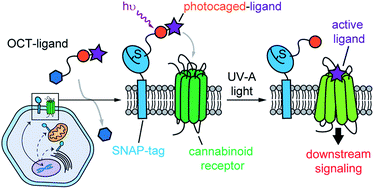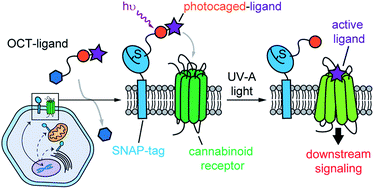

Image is from Tobias et. al, $Chem. Sci.$, 2021, 12, 13506–13512. 

OCTPEA binds to mebrane SNAP-tags and does not allow for dye to bind to SNAP-tag. DMSO does not bind to SNAP-tags. Membrane SNAP-tags tethered to a dye (Alexa 488).

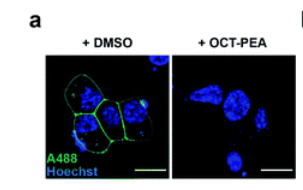

# Familiarzing ourselves with Ca <sup>2+ </sup> Imaging data 
For this notebook, we will only be using a small portion of the data published in Tobias et. al, $Chem. Sci.$, 2021, 12, 13506–13512.

Here, we have 3 different ligand conditions: Dimethyl sulfoxide (DMSO, vehicle control), OCTPEA, and CID 16020046 (CID, a selective GPR55 antagonist). 



Note that these Ca<sup>2+</sup> Imaging files are separated by condition and each condition has multiple trials. Each trial is a .csv file that has data collected from a live video. In our .cvs file, each row is a frame in the video (there are a total of 410 frames in these videos) and the columns of our .csv file represent a cell- each trial has a different number of cells. The numbers represent changes in fluorescence intensity of our Ca<sup>2+</sup> sensor in every cell at every frame. 
## Exercise 1 
Sometimes we might have all of our data in one file as we slowly collect it. As we have seen in the last 9 weeks, lets take a look at one of our DMSO (vehicle control) trials. Using the pd.read_csv function, make it an array and save our DMSO1 trial to DMSO_trial1. 
###### How many cells are in our DMSO trial 1? (hint: check its shape)

In [37]:
#Answer 
D= pd.read_csv('data/DMSO/DMSO1.csv', header=None,index_col=0)
DMSO_trial1=D.values
print("DMSO_trial1 has",DMSO_trial1.shape[1], "cells")

DMSO_trial1 has 66 cells


## Normalizing Our Data 
For all of our data sets we will normalize our data to the mean of first 5 frames to every cell. 

In [92]:
baseline=np.mean(DMSO_trial1[:5,:],axis=0,keepdims=True)

## Exercise 2 
Normalize DMSO_trial1 to the baseline and set this to  DMSO_trial1_norm.

In [93]:
#Answer 
DMSO_trial1_norm= DMSO_trial1/baseline 

## Measuring Changes in Oscillations  
In our analysis we want to investigate how photo releasing PEA affects [Ca<sup>2+</sup>] oscillations and one way to do this is by looking at changes in peaks of fluorescence intensity of our Ca<sup>2+</sup> sensor. 

Images below are from https://blog.ytotech.com/2015/11/01/findpeaks-in-python/ 

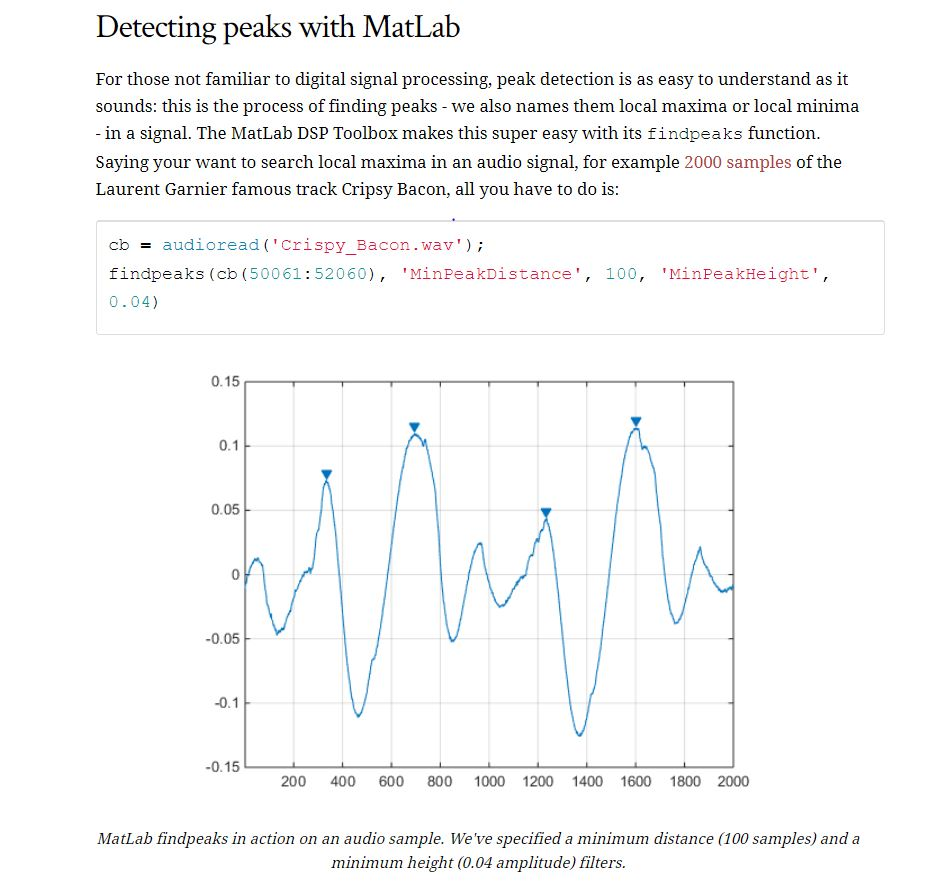

#### There is no findpeaks function in python, but Marcos Duarte wrote a package called "detecta" to help us detect peaks with python the way we would in  matlab (https://nbviewer.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb). 

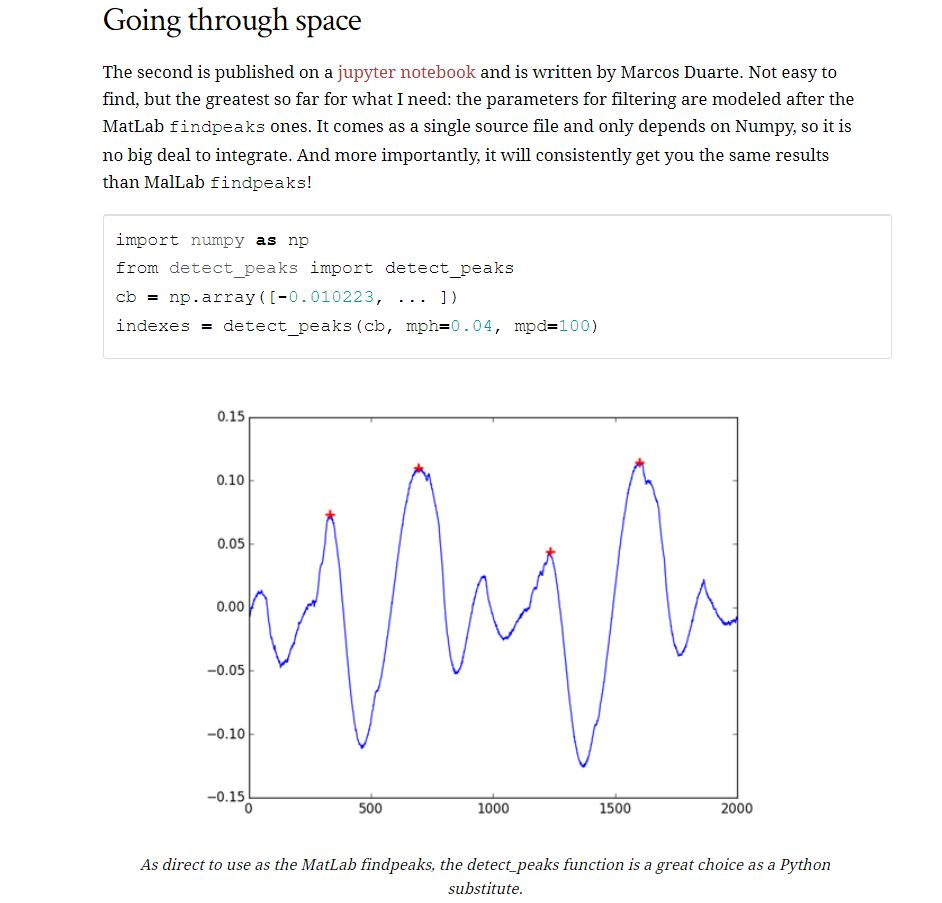

## Let's Find Some Peaks in Our Data 
In these live imaging videos to release PEA from its photocage, we use UV irradition (375 nm) at two different time points for 15 frames. 
Here I am finding the peaks before irradtion using detect_peaks for all cells in DMSO_trial1_norm. Because we have multiple cells in our array, we need a for loop to detect the peaks for each one. 
Some key arguments for detect peaks: 
* mph : essentially our peak height along the y axis. Our threshold here is 1.25, so peaks accounted for must  be 1.25 greater than the signal before and after 
* mpd: finds the tallest peak and elimnates peaks in x direction on either side of the peak. Here, our threshold is 2. 


In [102]:
UV1f= 150 #frame number where first irradiation occurred
ypeakthreshold= 1.25 
xpeakthreshold= 2
all_peaks=[] #empty list for all of our peaks 
all_cells_peaks = list() #will later store the number of peaks per cell 
for cell  in range(DMSO_trial1_norm.shape[1]):                   
    findprepeak= detect_peaks(DMSO_trial1_norm[:UV1f,cell], mph=ypeakthreshold, mpd=xpeakthreshold) #finding peaks of cells in all the frames before UV
    all_peaks.append(findprepeak)
    all_cells_peaks.append(len(findprepeak))
mean_peak_count = sum(all_cells_peaks) / DMSO_trial1_norm.shape[1] #want the mean number of peaks in this trial to later find our oscillation frequency
mean_peak_count

10.348484848484848

In [95]:
def peak_plot(cell,trial,peaks):
    fig, ax = plt.subplots()
    ax.plot(trial[:UV1f,cell]); 
    ax.scatter(peaks[cell], trial[:UV1f,cell][peaks[cell]], color="red" )
    return fig, ax

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

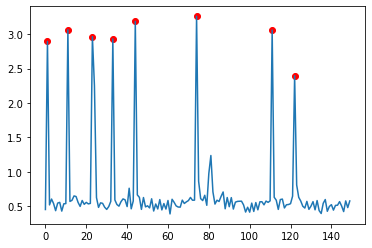

In [99]:
peak_plot(0,DMSO_trial1_norm, all_peaks) 

##

In [100]:
DMSO_trial1_norm[0:150,cell][all_peaks[cell]]

#DMSO_trial1_norm[0:150,:][all_peaks[0],0]

array([1.44337763, 6.06322455, 1.25077141, 1.26841621, 1.28729438,
       6.03990446, 1.64795334, 1.43757944, 1.28124745])

In [41]:
#testing 
D2= pd.read_csv('data/DMSO/DMSO2.csv', header=None,index_col=0)
DMSO_trial2=D2.values
baseline2=np.mean(DMSO_trial2[:5,:],axis=0,keepdims=True)
DMSO_trial2_norm= DMSO_trial2/baseline2 

In [42]:
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300
ypeakthreshold= 1.25 #only count peak if it is 1.25 larger, peak must be at least this value greater in y than signal before / after, mph 
xpeakthreshold= 2 #finds tallest peak and eliminates peak in x direction on either side of peak mpd, 
all_peaks=[]
all_cells_peaks = list()
for cell  in range(DMSO_trial2_norm.shape[1]):                   #here if I dind one peak mtg my y condition, I eliminate all peaks 2 positions to the left and right
    findprepeak= detect_peaks(DMSO_trial2_norm[:UV1f,cell], mph=ypeakthreshold, mpd=xpeakthreshold) #find peaks withindataset and generate an array
    all_peaks.append(findprepeak)
    all_cells_peaks.append(len(findprepeak))
mean_peak_count = sum(all_cells_peaks) / DMSO_trial2_norm.shape[1]
mean_peak_count

12.64406779661017

## Exercise 2 
For DMSO_trial1_norm, find the peaks in the frames between UV1f and UVf2 and set these to "findpostpeak." Then, normalize the number of findpostpeak to the total number of cells in DMSO_trial1- set this to "postpeaksnorm."

In [227]:
#answer 
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300
ypeakthreshold= 1.25 #only count peak if it is 1.25 larger, peak must be at least this value greater in y than signal before / after, mph 
xpeakthreshold= 2 #finds tallest peak and eliminates peak in x direction on either side of peak mpd, 
all_postpeaks=[]
allpost_cells_peaks = list()
for cell  in range(DMSO_trial1_norm.shape[1]):                 
    findpostpeak= detect_peaks(DMSO_trial1_norm[UV1f:UV2f,cell], mph=ypeakthreshold, mpd=xpeakthreshold) #find peaks withindataset and generate an array
    all_postpeaks.append(findprepeak)
    allpost_cells_peaks.append(len(findpostpeak))
mean_post_peak_count = sum(allpost_cells_peaks) / DMSO_trial1_norm.shape[1]
mean_post_peak_count 

12.787878787878787

# Organizing Our Data to Find Fold Changes in Peaks 
We have 3 different Conditions: DMSO, GPR55 Inhibitor (CID for short), and OCTPEA. Let's say you cannot remember what conditions are in your data folder. Using pathlib's function pl.path, we can look at all the items in our data folder like so. 

In [43]:
datapath=pl.Path("data")
print (list(datapath.iterdir()))

[WindowsPath('data/DMSO'), WindowsPath('data/GPR55 Inhibitior'), WindowsPath('data/OCTPEA'), WindowsPath('data/traces_15_131_2_CFP.csv'), WindowsPath('data/traces_15_131_2_YFP.csv')]


Each output is a different folder. I separated all my paths for each condition in order to pull all the trials within each condition later.

In [44]:
DMSOpath = 'data/DMSO/' # use your path
DMSOfiles = glob.glob(DMSOpath + "/*.csv")
OCTPEApath= 'data/OCTPEA' 
OCTfiles= glob. glob(OCTPEApath +"/*.csv") 
CIDpath= 'data/GPR55 Inhibitior' 
CIDfiles=glob. glob(CIDpath +"/*.csv") 

In [113]:
#data_ins.clear() 
#conditions.clear() 

In [45]:
data_ins= []
conditions = []
for filename in DMSOfiles:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        d = df.values
        print("d.shape:",d.shape)
        dmean=np.mean(d[:5,:],axis=0,keepdims=True)
        print("dmean shape:", dmean.shape)
        d /= dmean
        data_ins.append(d)
        conditions.append('DMSO')

d.shape: (410, 66)
dmean shape: (1, 66)
d.shape: (410, 59)
dmean shape: (1, 59)
d.shape: (410, 50)
dmean shape: (1, 50)
d.shape: (410, 72)
dmean shape: (1, 72)


In [46]:
for filename in OCTfiles:
    df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
    d = df.values
    dmean=np.mean(d[:5,:],axis=0,keepdims=True)
    d /= dmean
    data_ins.append(d)
    conditions.append('OCTPEA')

## Exercise 3 
Now, add the CID files to the data_ins and conditions lists. 

In [47]:
#Answer
for filename in CIDfiles:
    df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
    d = df.values
    dmean=np.mean(d[:5,:],axis=0,keepdims=True)
    d /= dmean
    data_ins.append(d)
    conditions.append('CID')

In [48]:
cellcounts=[d.shape[1] for d in data_ins]
print(cellcounts)
print(conditions) 

[66, 59, 50, 72, 70, 28, 37, 64, 82, 24, 47, 46, 66, 30, 56, 60]
['DMSO', 'DMSO', 'DMSO', 'DMSO', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'CID', 'CID', 'CID', 'CID']


## Finding Peaks for Multiple Data Sets *****
Now that we have all of our data arrays organized in a list, we can find peaks for all of trials within each condition in an organized way. 


In [289]:
#want a code that will do all this for each individual trial 
#and will store all the mean peak counts corresponding to that trial
#the mistake I keep getting is that all_cells_peaks are being stored together in one list and my code is basically summing the peaks for ALL trials 
#I do not want that. 
#I only want it to sum the peaks for each individual trial and divide by each trial's cell number
# the only problem is that each trial does not give out one peak or a certain number of peaks- it varies. could be 200 peaks for all total cells or 100. 
#how do I write a code to evade this problem and still do this for all my trials without having to repeat the same lines of code over and over?? 
#idea is to maybe write a function thatll do it for each individual array in data_ins and append the result to an empty list for each trial. 
#fold change will post peaksnorm/prepeknorm 

In [49]:
#finds tallest peak and eliminates peak in x direction on either side of peak mpd, 
def find_prepeaks(d): 
    UV1f= 150 
    all_cells_prepeaks=list()
    for cell  in range(d.shape[1]):                   
        findprepeak= detect_peaks(d[:UV1f,cell], mph=1.25, mpd=2)
        all_cells_prepeaks.append(len(findprepeak))
    mean_peak_count = sum(all_cells_prepeaks) / d.shape[1]
    return mean_peak_count

## Exercise 4 
Write a function to find the peaks after the first irradiation, UV1f, and before the second irradiation, UV2f, and call the fuction find_postpeaks. 

In [50]:
#Answer 
def find_postpeaks(d): 
    UV1f= 150 
    UV2f= 300
    all_cells_prepeaks=list()
    for cell  in range(d.shape[1]):                   
        findprepeak= detect_peaks(d[UV1f:UV2f,cell], mph=1.25, mpd=2)
        all_cells_prepeaks.append(len(findprepeak))
    mean_peak_count = sum(all_cells_prepeaks) / d.shape[1]
    return mean_peak_count

In [52]:
DMSO_prepeaks=[]
DMSO_postpeaks=[] 
for i in data_ins[:4]: 
    b=find_prepeaks(i) 
    DMSO_prepeaks.append(b) 
    c=find_postpeaks(i) 
    DMSO_postpeaks.append(c)
DMSO_prepeaks, DMSO_postpeaks 

([10.348484848484848, 12.64406779661017, 14.34, 12.694444444444445],
 [12.787878787878787, 14.11864406779661, 17.76, 14.958333333333334])

## Exercise 5 
Now, using the two finding peaks functions, write a script that will store all of your peaks before and after irradiation in two seperate lists: peaks_before_flash and peaks_after_flash. 

In [55]:
#Answer 
peaks_before_flash =[]
peaks_after_flash=[]
for i in data_ins: 
    b=find_prepeaks(i) 
    peaks_before_flash.append(b) 
    c=find_postpeaks(i) 
    peaks_after_flash.append(c)

[10.348484848484848, 12.64406779661017, 14.34, 12.694444444444445]

# Fold Change 

In [56]:
DMSO_prepeaks=peaks_before_flash[:4]
DMSO_postpeaks=peaks_after_flash[:4]
DMSO_foldchanges=[]
for i in range(len(DMSO_prepeaks)): 
    foldchange=DMSO_postpeaks[i]/DMSO_prepeaks[i]
    DMSO_foldchanges.append(foldchange) 
DMSO_foldchanges 

[1.2357247437774523, 1.116621983914209, 1.2384937238493725, 1.1783369803063457]

In [57]:
def foldchanges(pre,post): 
    condition_foldchanges=[]
    for i in range(len(pre)): 
        foldchange=post[i]/pre[i] 
        condition_foldchanges.append(foldchange) 
    return condition_foldchanges

## Exercise 5 
Slice out the OCT and CID peaks before and after irradiation. 
OCTPEA trials in our lists are [4:12]
CID trials in our lists are [12:16]

In [58]:
OCTPEA_prepeaks=peaks_before_flash[4:12]
OCTPEA_postpeaks=peaks_after_flash[4:12]
CID_prepeaks=peaks_before_flash[12:16]
CID_postpeaks=peaks_after_flash[12:16]

In [59]:
DMSO_foldchanges=foldchanges(DMSO_prepeaks,DMSO_postpeaks)
OCTPEA_foldchanges=foldchanges(OCTPEA_prepeaks, OCTPEA_postpeaks) 
CID_foldchanges=foldchanges(CID_prepeaks, CID_postpeaks) 

0.01479532022133389

[0.0033138988018418998, 0.16566871716331896, 0.037380422939961806]

### Mean Fold Changes 

In [60]:
DMSO_meanfold=np.mean(DMSO_foldchanges) 
OCTPEA_meanfold=np.mean(OCTPEA_foldchanges) 
CID_meanfold=np.mean(CID_foldchanges)

In [73]:
allfolds={'DMSO' : DMSO_foldchanges,'OCTPEA' : OCTPEA_foldchanges,'CID' : CID_foldchanges}
folds=pd.DataFrame({ key:pd.Series(value) for key, value in allfolds.items() })
folds

DMSO    OCTPEA       CID
0  1.235725  1.665428  1.160480
1  1.116622  1.703504  1.440433
2  1.238494  2.408784  0.997361
3  1.178337  1.374202  1.324378
4       NaN  1.536723       NaN
5       NaN  2.429688       NaN
6       NaN  1.801739       NaN
7       NaN  1.461538       NaN

(<AxesSubplot:xlabel='Condition', ylabel='Oscillation Frequency (Fold Change)'>,
 <AxesSubplot:xlabel='Condition', ylabel='Oscillation Frequency (Fold Change)'>)

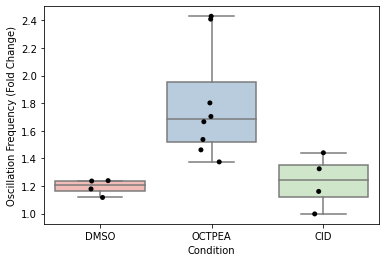

In [64]:
b=sns.boxplot(data=folds,palette='Pastel1') 
b.set(xlabel='Condition',ylabel='Oscillation Frequency (Fold Change)')
d=sns.stripplot(data=folds, color="Black") 
b,d

## Statistics On Our Fold Changes 

In [27]:
stat, p = bartlett(DMSO_foldchanges, OCTPEA_foldchanges, CID_foldchanges)

In [28]:
ss.kruskal(DMSO_foldchanges, OCTPEA_foldchanges, CID_foldchanges)

KruskalResult(statistic=10.648897058823536, pvalue=0.004871036507044393)

In [30]:
sp.posthoc_dunn([DMSO_foldchanges, OCTPEA_foldchanges, CID_foldchanges], p_adjust = 'bonferroni')

1         2         3
1  1.000000  0.015967  1.000000
2  0.015967  1.000000  0.034257
3  1.000000  0.034257  1.000000

In [85]:
pairs = [('DMSO', 'OCTPEA'),  
         ('OCTPEA', 'CID'),  
         ('DMSO', 'CID')] 

In [ ]:
data_ins= []
conditions = []
for filename in DMSOfiles:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        d = df.values
        print("d.shape:",d.shape)
        dmean=np.mean(d[:5,:],axis=0,keepdims=True)
        print("dmean shape:", dmean.shape)
        d /= dmean
        data_ins.append(d)
        conditions.append('DMSO')

In [242]:
#testing my function 
b=[]
for i in data_ins: 
    b.append(i.shape[1])
b

[66, 59, 50, 72, 70, 28, 37, 64, 82, 24, 47, 46, 66, 30, 56, 60]

0.16666666666666666

In [442]:
#Organizing all of our repeated data 
Nconditions= 3 #Number of conditions 

#Number of files per condition 
DMSOFileN= 4 # vehicle control repeats in separate files
ProbeFileN= 8 #probe repeats in separate files 
CIDFileN= 4 #probe with gpr55 inhibitor repearts in separate files 

In [80]:
#Setting experimental parameters to analyze and plot data
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300 #frame number where second irradiation occurred 
UVdur= 15 #number of frames for each irradiation 
posctrlf= 400 #frame number where positive control was added 
frametime= 4 #experiment was conducted by imaging 4 sec per frame 
#convert units from frames to seconds 
UV1= UV1f*frametime-frametime 
UV2= UV2f*frametime-frametime
UVdur= UVdur*frametime
posctrl= posctrlf*frametime-frametime 

In [82]:
print (list(datapath.iterdir())) 

[WindowsPath('data/DMSO'), WindowsPath('data/GPR55 Inhibitior'), WindowsPath('data/OCTPEA'), WindowsPath('data/traces_15_131_2_CFP.csv'), WindowsPath('data/traces_15_131_2_YFP.csv')]


## Ploting Our Data
Here instead of having a list of arrays, we have mean of all of our cell traces within each trial for every condition. 

In [6]:
#want to normalize all of my data within each individual trial within each condition 

In [86]:
baseline = np.mean(df.values[:5,:], axis=0)
baseline.shape
n=df.values/baseline 


In [87]:
c=np.concatenate(consolidated_norm, axis=1)
c.shape

(410, 247)

In [ ]:
DMSOpath = 'data/DMSO/' # use your path
DMSOfiles = glob.glob(DMSOpath + "/*.csv")
OCTPEApath= 'data/OCTPEA' 
OCTfiles= glob. glob(OCTPEApath +"/*.csv") 
CIDpath= 'data/GPR55 Inhibitior' 
CIDfiles=glob. glob(Ihibpath +"/*.csv") 

In [351]:
def meanofalltrials(filelist):
    consolidated_norm= list()
    for filename in filelist:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        baseline = np.mean(df.values[:5,:], axis=0)
        baseline.shape
        n=df.values/baseline 
        consolidated_norm.append(n)
    concat_cells=np.concatenate(consolidated_norm, axis=1)
    meanovertime=np.mean(concat_cells, axis=1) 
    return meanovertime

In [445]:
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300 #frame number where second irradiation occurred 
UVdur= 15 #number of frames for each irradiation 
kcl= 400 #frame number where positive control was added 
frametime= 4 #experiment was conducted by imaging 4 sec per frame 
#convert units from frames to seconds 
UV1= UV1f*frametime-frametime 
UV2= UV2f*frametime-frametime
UVdur= UVdur*frametime
kcl_time=kcl*frametime-frametime

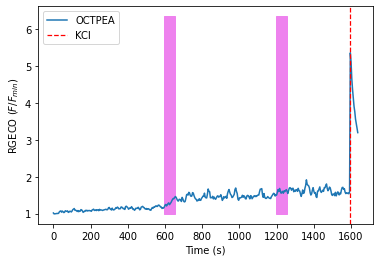

In [446]:
octpea=meanofalltrials(OCTfiles)  
frametime=4 
times= np.arange(octpea.shape[0])*frametime
fig, ax = plt.subplots()
plt.plot(times, octpea, label="OCTPEA")
ax.add_patch(Rectangle((UV1,min(octpea)),UVdur, max(octpea),color="violet"))
ax.add_patch(Rectangle((UV2,min(octpea)),UVdur, max(octpea),color="violet"))
plt.axvline(kcl_time, color ="red", linestyle='--', label="KCl", linewidth=1.25)
ax.set_xlabel("Time (s)") 
ax.set_ylabel("RGECO $(F/F_{min})$") 
plt.legend()

In [90]:
#ctrl 

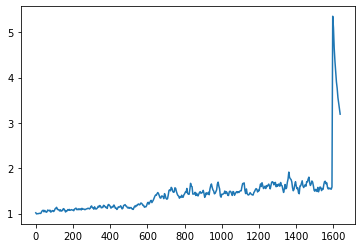

In [354]:
octpea=meanofalltrials(OCTfiles)  
frametime=4 
times= np.arange(octpea.shape[0])*frametime
plt.plot(times, octpea)

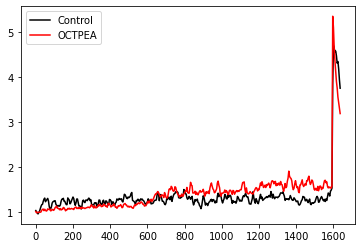

In [359]:
fig, ax = plt.subplots()
ax.plot(times, ctrl, color='black', label='Control')
ax.plot(times, octpea, color='red', label='OCTPEA')
plt.legend()

In [93]:
#finding peaks before and after UV Stimulation 
#Need to know number of conditions
#array to hold number of cells per trial.. number of cells per trial will be # of items in axis 1 
#array to hold normalized traces per trial 
#we have varying oscillatory ca peaks 
#going to use function detect_peaks similar to matlab find_peaks 
#mph is mean peak height and mpd is mean peak distance 


5.354556557425622

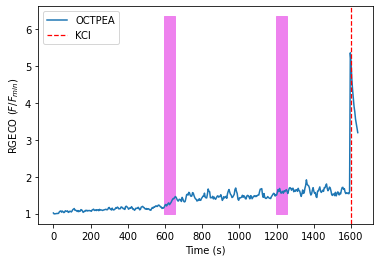

In [421]:
octpea=meanofalltrials(OCTfiles)  
frametime=4 
times= np.arange(octpea.shape[0])*frametime
fig, ax = plt.subplots()
plt.plot(times, octpea, label="OCTPEA")
ax.add_patch(Rectangle((UV1,min(octpea)),UVdur, max(octpea),color="violet"))
ax.add_patch(Rectangle((UV2,min(octpea)),UVdur, max(octpea),color="violet"))
plt.axvline(kcl_time, color ="red", linestyle='--', label="KCl", linewidth=1.25)
ax.set_xlabel("Time (s)") 
ax.set_ylabel("RGECO $(F/F_{min})$") 
plt.legend()

In [20]:
DMSOfiles = glob.glob(DMSOpath + "/*.csv")


['data/DMSO\\DMSO1.csv',
 'data/DMSO\\DMSO2.csv',
 'data/DMSO\\DMSO3.csv',
 'data/DMSO\\DMSO4.csv']

In [35]:
DMSOfiles = glob.glob(DMSOpath + "/*.csv")
DMSOFileN= 4 
condition = []
for i, DMSOfile filename in enumerate(DMSOfiles):
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        str(condition)= df
        condition += 1
        print(condition.shape) 
        
 

SyntaxError: cannot assign to operator (Temp/ipykernel_22624/3484746988.py, line 6)

In [48]:
DMSOfiles = glob.glob(DMSOpath + "/*.csv")

DMSOFileN= 4 
data_in = []
condition = []
for filename in DMSOfiles:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        d = df.values
        print("d.shape:",d.shape)
        dmean=np.mean(d[:5,:],axis=0,keepdims=True)
        print("dmean shape:", dmean.shape)
        d /= dmean
        data_in.append(d)
        condition.append('DMSO')
#for d in data_in:
#    print(d.shape)
import matplotlib.pyplot as plt
#plt.plot(data_in[1]);


d.shape: (410, 66)
dmean shape: (1, 66)
d.shape: (410, 59)
dmean shape: (1, 59)
d.shape: (410, 50)
dmean shape: (1, 50)
d.shape: (410, 72)
dmean shape: (1, 72)


In [52]:
d[0]

array([1.14242941, 0.44419167, 1.15494149, 1.14085845, 0.73119485,
       0.92450861, 1.05091013, 0.66412211, 1.00255557, 0.89724401,
       1.03014506, 1.25300246, 3.00079177, 0.96491124, 0.78273525,
       1.33155975, 1.17808835, 1.75918205, 1.81461087, 0.96663241,
       0.89348238, 1.08118074, 0.46954016, 0.92653733, 0.7887004 ,
       1.10767179, 0.93242499, 2.0512895 , 1.00662095, 0.9552648 ,
       0.661507  , 1.11954194, 0.81553522, 0.87238925, 0.30978487,
       1.12443407, 0.87998102, 1.0971207 , 1.01225475, 2.19085475,
       0.98490091, 0.72402348, 1.16216252, 0.91686861, 0.93533111,
       0.83369058, 1.1801721 , 0.42082881, 1.2621242 , 0.65714702,
       0.35732827, 0.86495793, 0.87582951, 0.70012313, 1.04760587,
       1.03498353, 1.03553345, 2.3411392 , 1.04079342, 1.13827921,
       0.967504  , 0.91854741, 1.18946955, 0.89099779, 1.634629  ,
       0.97024108, 1.05874696, 1.54397356, 0.96016634, 0.92325283,
       1.08109307, 1.        ])

In [55]:
OCTPEAfiles = glob.glob('data/OCTPEA' + "/*.csv")
for filename in OCTPEAfiles:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        d = df.values
        print("d.shape:",d.shape)
        dmean=np.mean(d[:5,:],axis=0,keepdims=True)
        print("dmean shape:", dmean.shape)
        d /= dmean
        data_in.append(d)
        condition.append('OCTPEA')
#for d in data_in:
#    print(d.shape)
import matplotlib.pyplot as plt
#plt.plot(data_in[1]);


d.shape: (410, 70)
dmean shape: (1, 70)
d.shape: (410, 28)
dmean shape: (1, 28)
d.shape: (410, 37)
dmean shape: (1, 37)
d.shape: (410, 64)
dmean shape: (1, 64)
d.shape: (410, 82)
dmean shape: (1, 82)
d.shape: (410, 24)
dmean shape: (1, 24)
d.shape: (410, 47)
dmean shape: (1, 47)
d.shape: (410, 46)
dmean shape: (1, 46)


In [60]:
cellcounts=[d.shape[1] for d in data_in]
print(cellcounts)
print(condition)

[66, 59, 50, 72, 70, 28, 37, 64, 82, 24, 47, 46]
['DMSO', 'DMSO', 'DMSO', 'DMSO', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA']


# section A

## Exercise - do something

enter code to 

### Exercise - do something

<img src="images/photo.jpg">

* item 1
* item 2

make filename "XXX_base.ipynb"  enter code to 

In [ ]:
# Answer
a = 3


In [ ]:
mean_peaks_before =[]
mean_peaks_after []
for d in data_in:
    a=count_peaks_before_flash(d) / number of colimns in d
    b=count_peaks_after(d)/number of columns
    mean_peaks_before.append(a)
    mean_peaks_after.append(b)
    

In [20]:
#want to find peaks before and after UV irradiation 
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300
ypeakthreshold= 1.25 #peak must be at least this value greater in y than signal before / after, mph 
xpeakthreshold= 2 #finds tallest peak and eliminates peak in x direction on either side of peak mpd
for i in np.arange(data_in.shape[1]): # for i in the total number of cells in concatinated normalized controls 
    findprepeak= detect_peaks(ctrl_trials[UV1f-1], mph=ypeakthreshold, mpd=xpeakthreshold) #find peaks withindataset and generate an array
prepeaksnorm=len(findprepeak)/ctrl_trials.shape[1]
    #findpostpeak=len(detect_peaks(ctrl_trials[UV1f:UV2f], mph=ypeakthreshold, mpd=xpeakthreshold)) 
len(findprepeak)

42

In [34]:
condition4

NameError: name 'condition4' is not defined

In [17]:
#need a function to just return thr concatinated cells 
DMSOfiles = glob.glob(DMSOpath + "/*.csv")
DMSOFileN= 4 
def trials(filelist,condition,):
    consolidated_norm= list()
    condition= 
    for i, filename in enumerate(filelist):
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        condition= df[i]
    return condition
ctrl_trials=trials(DMSOfiles,DMSO) 
ctrl_trials

KeyError: 0

In [11]:
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300
pre_peaks = ctrl_trials[UV1f-1]

In [20]:
#want to find peaks before and after UV irradiation 
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300
ypeakthreshold= 1.25 #peak must be at least this value greater in y than signal before / after, mph 
xpeakthreshold= 2 #finds tallest peak and eliminates peak in x direction on either side of peak mpd
for i in np.arange(ctrl_trials.shape[1]): # for i in the total number of cells in concatinated normalized controls 
    findprepeak= detect_peaks(ctrl_trials[UV1f-1], mph=ypeakthreshold, mpd=xpeakthreshold) #find peaks withindataset and generate an array
prepeaksnorm=len(findprepeak)/ctrl_trials.shape[1]
    #findpostpeak=len(detect_peaks(ctrl_trials[UV1f:UV2f], mph=ypeakthreshold, mpd=xpeakthreshold)) 
len(findprepeak)

42

In [21]:

y =pre_peaks[findprepeak].sum()
len(findprepeak)

42

In [137]:
ctrl_trials.shape[1]

247

In [155]:
ctrl_trials[UV1f:UV2f].shape

(150, 247)

In [154]:
ctrl_trials[:UV1f-1].shape

(149, 247)

In [ ]:
cfp = CFP_3UV_df.values
yfp = YFP_3UV_df.values

fret=cfp/yfp 
cellmax= fret.max(axis=0)
normfret=fret/cellmax
meannormfret=normfret.mean(axis=1)
plt.plot(meannormfret.T)